<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Escreva uma breve descrição do problema.

## 2\. Pacotes e bibliotecas

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [ ]:
# importe todas as suas bibliotecas aqui, siga os padrões do PEP8:
# - 1º pacotes nativos do python: json, os, etc.;
# - 2º pacotes de terceiros: pandas, seabornm etc.;
# - 3º pacotes que você desenvolveu.
#

!pip install geopy
!pip install geopandas
!pip install geobr
!pip install descartes

import pandas as pd
import requests
import seaborn as sns
import geopandas as gpd
import geobr
import matplotlib.pyplot as plt
...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.1/928.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.8 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.2
    Uninstalling shapely-2.0.2:
      Successfully uninstalled shapely-2.0.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.10.0 requires geopandas>=0.12.2, but you have geopandas 0.7.0 which is incompatible.


Ellipsis

## 3\. Exploração de dados

In [ ]:
url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json'
nome_arquivo = 'deliveries.json'
aux = requests.get(url)
with open(nome_arquivo, 'wb') as fp:
    fp.write(aux.content)

url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv'
nome_arquivo = 'deliveries-geodata.csv'
aux = requests.get(url)
with open(nome_arquivo, 'wb') as fp:
    fp.write(aux.content)

info_bases = pd.read_json("deliveries.json")
info_entregas = pd.read_csv("deliveries-geodata.csv", header = 0)
# - coleta de dados;
# - wrangling da estrutura;
# - exploração do schema;
# - etc.

## 4\. Manipulação

In [ ]:
# faça o código de manipulação de dados:
# - enriquecimento;
# - controle de qualidade;
# - etc.
info_bases = pd.merge(left=info_bases, right=info_entregas, how="inner", left_index=True, right_index=True)
info_bases_normalized= pd.json_normalize(info_bases["origin"])
info_bases = pd.merge(left=info_bases, right=info_bases_normalized, how="inner", left_index=True, right_index=True)

info_bases = info_bases.drop(["origin", "delivery_lat", "delivery_lng"], axis=1)
info_bases = info_bases.rename(columns={
"name":"Nome",
"region": "Base",
"vehicle_capacity":"Capacidade_Veiculo",
"deliveries":"Entregas",
"lng":"lng_base",
"lat":"lat_base",
"delivery_city": "Cidade_entrega",
"delivery_suburb":"Região_entrega"
})

info_bases = info_bases[["Nome", "Base", "lng_base", "lat_base", "Cidade_entrega", "Região_entrega","Capacidade_Veiculo", "Entregas"]]
bases_exploded = info_bases[["Entregas"]].explode("Entregas")
bases_exploded = pd.concat([
    pd.DataFrame(bases_exploded["Entregas"].apply(lambda extrair: extrair["size"])).rename(columns={"Entregas":"Tamanho_Entrega"}),
    pd.DataFrame(bases_exploded["Entregas"].apply(lambda extrair: extrair["point"]["lng"])).rename(columns={"Entregas":"lng_entrega"}),
    pd.DataFrame(bases_exploded["Entregas"].apply(lambda extrair: extrair["point"]["lat"])).rename(columns={"Entregas":"lat_entrega"}),
],axis=1)

info_bases = info_bases.drop("Entregas", axis=1)
info_bases = pd.merge(left=info_bases, right=bases_exploded, how="right", left_index=True, right_index=True)
info_bases.reset_index(inplace=True, drop=True)
info_bases[["Cidade_entrega", "Região_entrega"]] = info_bases[["Cidade_entrega", "Região_entrega"]].fillna("Indisponível") #Usando o fillna para alterar e renomear as colunas nulas

## 5\. Visualização

In [ ]:
# faça o código de visualização de dados:
#
# - produza pelo menos duas visualizações;
# - adicione um pequeno texto com os insights encontrados;
# - etc.

mapa_distrito = geobr.read_municipality(code_muni='DF', year=2020)

geo_base = info_bases[["Base", "lng_base", "lat_base"]].drop_duplicates().reset_index(drop= True)
geo_base_df = gpd.GeoDataFrame( geo_base, geometry=gpd.points_from_xy( geo_base["lng_base"], geo_base["lat_base"] ) )

geo_entregas_df = gpd.GeoDataFrame( info_bases, geometry=gpd.points_from_xy( info_bases["lng_entrega"], info_bases["lat_entrega"]))

total_entregas = info_bases['Tamanho_Entrega'].sum()

total_entregas_base = info_bases[['Base', 'Tamanho_Entrega']].groupby("Base").agg("sum").reset_index()
total_entregas_base ['porcentagem_total_entregas'] = round(total_entregas_base ['Tamanho_Entrega'] / total_entregas, 2)
total_entregas_base.rename(columns={'Tamanho_Entrega':'total_base', "Base":"região"}, inplace=True)
total_entregas_base

rank_cidades_entregas = info_bases["Cidade_entrega"].value_counts().reset_index()
rank_cidades_entregas.rename(columns={"index":"cidade", "Cidade_entrega": "qtd_entregas"}, inplace=True)

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/usr/local/lib/python3.10/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


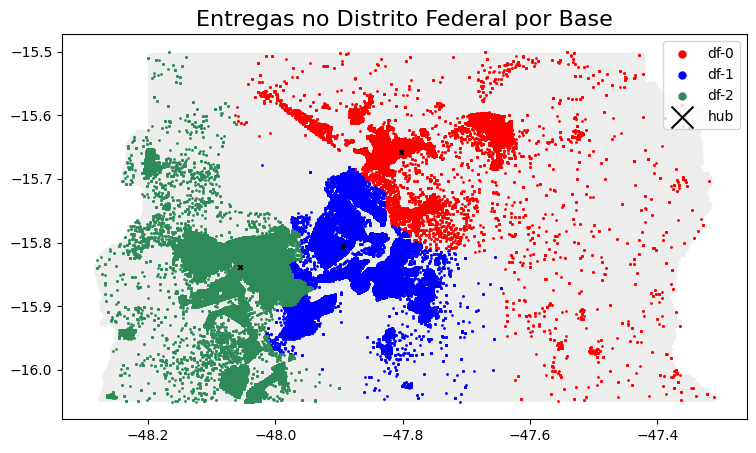

In [ ]:
grafico_1, ax = plt.subplots(figsize=(10, 5))
mapa_distrito.plot(ax=ax, alpha=0.4, color="lightgrey")
geo_entregas_df.query("Base == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_entregas_df.query("Base == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_entregas_df.query("Base == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")
geo_base_df.plot( ax=ax, markersize=10, marker="x", color="black", label="hub" )
plt.title( "Entregas no Distrito Federal por Base", fontdict={"fontsize": 16} )
lgnd = plt.legend(prop={"size": 10}, markerscale=5, loc="upper right")

<ipython-input-7-7e269afc7985>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  total_entregas_grafico = sns.barplot(data=total_entregas_base, x='região', y='total_base', ci='sd', palette='muted')


[Text(0.5, 1.0, 'Entregas por base'),
 Text(0.5, 0, 'Bases'),
 Text(0, 0.5, 'Entregas (em milhares)')]

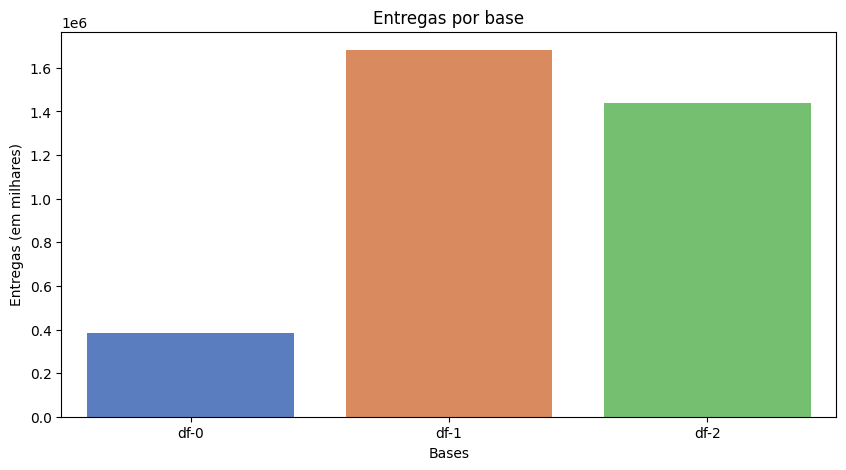

In [ ]:
grafico_2 = plt.figure(figsize=(10, 5))
total_entregas_grafico = sns.barplot(data=total_entregas_base, x='região', y='total_base', ci='sd', palette='muted')
total_entregas_grafico.set(title='Entregas por base', xlabel='Bases', ylabel='Entregas (em milhares)')

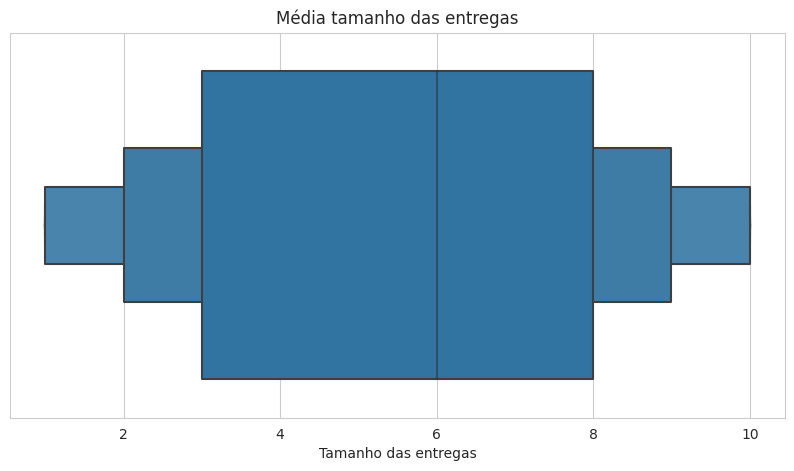

In [ ]:
with sns.axes_style("whitegrid"):
  grafico_3 = plt.figure(figsize=(10, 5))
  grafico_tamanho_entregas = sns.boxenplot(x=info_bases["Tamanho_Entrega"])
  grafico_tamanho_entregas.set(title="Média tamanho das entregas", xlabel="Tamanho das entregas")